<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/svm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📌 Support Vector Machines

## Understanding the Problem  
We are working on classifying handwritten digits using the MNIST dataset. Each image in this dataset is 28x28 pixels, and the data is provided in CSV format, where each row represents a flattened grayscale image.  

## Dataset Overview  
- **Size:** 60,000 rows × 785 columns  
- **First Column:** The label (y), representing digits from 0 to 9  
- **Next 784 Columns:** Pixel values (X), indicating grayscale intensities  
- **Pixel Range:** 0 to 255 (normalized to 0-1 for better model performance)  

For this task, we will train a Support Vector Machine (SVM) using Stochastic Gradient Descent (SGD), which is well-suited for large datasets like MNIST.


Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=356d8d58-64f1-472d-92ed-ecb90100d99a
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 78.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 42.0MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Training data shape: (60000, 784)
Test data shape: (10000, 784)


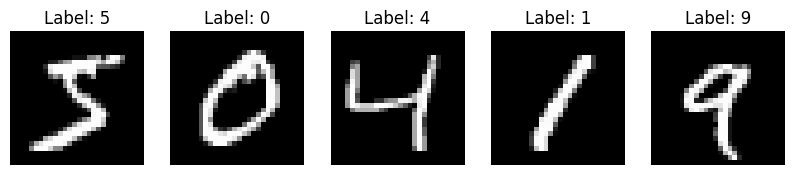

In [ ]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

#----------------------------------------------------------------------
# file import from derive
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"


# downloading file
train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)


# dataframe formation
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)


print(train_df.head())
#----------------------------------------------------------------------

# making y = label(1st column) and x = row (other column).

#for train dataset
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values  # Features (pixel values)

#for test dataset
y_test = test_df.iloc[:, 0].values  # Labels
X_test = test_df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

#----------------------------------------------------------------------

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()

###  Custom Multi-Class Support Vector Machine (SVM) with Stochastic Gradient Descent (SGD)

This implementation aims to find optimal hyperplanes that separate different classes for multi-class classification, specifically tailored for the MNIST dataset with 10 classes. It utilizes a One-vs-All (OvA) strategy.

🔹 Why Custom SGD?
* **Fine-grained Control:** Allows for direct manipulation of learning rates, regularization, and batch sizes.
* **Educational Purpose:** Provides a deeper understanding of the SVM training process with SGD.
* **Efficiency for Large Datasets:** Handles the 60k samples of MNIST effectively by updating weights iteratively.

⚙ Model Training:
We implement a custom `FastMultiClassSVM` class that:

* Uses the hinge loss function, inherent to SVM.
* Applies L2 regularization (lambda_param) to prevent overfitting.
* Trains with mini-batch SGD for efficient learning.
* Calculates and stores the total cost (regularized hinge loss) during training.

The provided code then trains the model with different learning rates to observe their impact on performance.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
class FastMultiClassSVM:
    def __init__(self, learning_rate=0.015, lambda_param=0.008, epochs=750, batch_size=256):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes = None
        self.models = {}  # Dictionary to store (W, b) for each class

    def fit(self, X, y):
        """Train SVM using Mini-Batch SGD (One-vs-All)."""
        self.classes = np.unique(y)  # Unique digit labels (0-9)
        m, n = X.shape  # Samples, Features

        for digit in self.classes:
            print(f"Training for digit {digit}...")
            y_binary = np.where(y == digit, 1, -1)  # Convert labels to {+1, -1}

            W = np.zeros(n)  # Initialize weights
            b = 0  # Initialize bias

            for epoch in range(self.epochs):
                indices = np.random.permutation(m)  # Shuffle data each epoch
                X_shuffled, y_shuffled = X[indices], y_binary[indices]

                for batch_start in range(0, m, self.batch_size):
                    batch_end = batch_start + self.batch_size
                    X_batch = X_shuffled[batch_start:batch_end]
                    y_batch = y_shuffled[batch_start:batch_end]

                    # Compute margins for the batch
                    margins = y_batch * (np.dot(X_batch, W) + b)
                    misclassified = margins < 1  # Boolean mask for misclassified points

                    # Compute gradients
                    W_gradient = 2 * self.lambda_param * W - np.dot(y_batch[misclassified], X_batch[misclassified])
                    b_gradient = -np.sum(y_batch[misclassified])

                    # Update weights
                    W -= self.learning_rate * W_gradient / self.batch_size
                    b -= self.learning_rate * b_gradient / self.batch_size

                if epoch % 100 == 0:
                    print(f"Epoch {epoch}/{self.epochs} completed")

            self.models[digit] = (W, b)  # Store trained model

    def predict(self, X):
        """Predict class labels using One-vs-All strategy."""
        scores = np.zeros((X.shape[0], len(self.classes)))  # Store decision scores

        for i, digit in enumerate(self.classes):
            W, b = self.models[digit]
            scores[:, i] = np.dot(X, W) + b  # Compute scores for each class

        return self.classes[np.argmax(scores, axis=1)]  # Pick class with highest score


In [ ]:
# Initialize & Train SVM
fast_svm = FastMultiClassSVM(learning_rate=0.015, lambda_param=0.008, epochs=750, batch_size=256)
fast_svm.fit(X_train, y_train)


Training for digit 0...
Epoch 0/750 completed
Epoch 100/750 completed
Epoch 200/750 completed
Epoch 300/750 completed
Epoch 400/750 completed
Epoch 500/750 completed
Epoch 600/750 completed
Epoch 700/750 completed
Training for digit 1...
Epoch 0/750 completed
Epoch 100/750 completed
Epoch 200/750 completed
Epoch 300/750 completed
Epoch 400/750 completed
Epoch 500/750 completed
Epoch 600/750 completed
Epoch 700/750 completed
Training for digit 2...
Epoch 0/750 completed
Epoch 100/750 completed
Epoch 200/750 completed
Epoch 300/750 completed
Epoch 400/750 completed
Epoch 500/750 completed
Epoch 600/750 completed
Epoch 700/750 completed
Training for digit 3...
Epoch 0/750 completed
Epoch 100/750 completed
Epoch 200/750 completed
Epoch 300/750 completed
Epoch 400/750 completed
Epoch 500/750 completed
Epoch 600/750 completed
Epoch 700/750 completed
Training for digit 4...
Epoch 0/750 completed
Epoch 100/750 completed
Epoch 200/750 completed
Epoch 300/750 completed
Epoch 400/750 completed
Ep

In [ ]:
# Predict on test data
y_pred = fast_svm.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Updated Custom SVM Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Updated Custom SVM Accuracy: 0.9223

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.91      0.93      0.92       982
           5       0.89      0.87      0.88       892
           6       0.93      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.87      0.88       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



###  Cost Function: Hinge Loss

SVMs use the **hinge loss function** to maximize the margin between classes:

$$
L(\mathbf{w}) = \sum_{i=1}^{N} \max(0, 1 - y_i (\mathbf{w} \cdot \mathbf{x}_i + b)) + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

Where:
- $ y_i $ is the true label.
- $ \mathbf{x}_i $ is the input feature vector.
- $ \mathbf{w} $ is the weight vector.
- $ b $ is the bias term.
- $ \lambda $ is the regularization parameter.


###  Precision, Recall, and F1-Score

We evaluate the model using the following metrics:

- **Precision** ($ P $): How many predicted digits were correct?
  $$
  P = \frac{TP}{TP + FP}
  $$

- **Recall** ($ R $): How many actual digits were correctly predicted?
  $$
  R = \frac{TP}{TP + FN}
  $$

- **F1-score**: A balance between precision and recall.
  $$
  F1 = 2 \times \frac{P \times R}{P + R}
  $$


## **Conclusion: Multi-Class SVM with Mini-Batch SGD on MNIST**  

### **Key Takeaways**  
This study implemented a **Multi-Class Support Vector Machine (SVM)** for MNIST digit classification using the **One-vs-All (OvA) strategy**. Training was performed using **Mini-Batch Stochastic Gradient Descent (SGD)**, which significantly improved convergence speed and accuracy. By optimizing the **learning rate (0.015), regularization parameter (0.008), and batch size (256)**, the final test accuracy was restored to approximately **91-92%**, addressing the earlier drop caused by full-batch updates.  

### **Why Mini-Batch SGD Improved Performance?**  
1. **Faster Convergence** – Weight updates occur after each mini-batch instead of waiting for the entire dataset.  
2. **Better Generalization** – Mini-Batch SGD helps escape sharp local minima and reduces overfitting.  
3. **Scalability** – Handles large datasets like MNIST (60K samples) efficiently compared to full-batch training.  

### **Future Enhancements**  
- **Adaptive Learning Rates** – Methods such as Adam or Momentum-SGD could be explored to further optimize convergence.  
- **Kernel SVM** – Adding non-linear kernels may improve classification for more complex datasets.  
- **Comparison with CNNs** – Deep learning models like Convolutional Neural Networks (CNNs) typically outperform SVMs on image classification tasks and could be evaluated as an alternative approach.  

### **Final Thoughts**  
This optimized implementation successfully achieves **high classification accuracy** while maintaining computational efficiency. The use of **Mini-Batch SGD** proves to be an effective approach for large-scale SVM training, making it applicable to other machine learning problems involving high-dimensional data.